In [2]:
import argparse
import os
import numpy as np
import math
import sys


import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from Tools import NNE

import matplotlib.cm as cm

from tqdm import trange

In [3]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
device

device(type='cuda', index=0)

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim,samples_dim,bias):
        super(Generator, self).__init__()
        self.bias=bias.clone().requires_grad_(False)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(1., inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, samples_dim)
        )

    def forward(self, z):
        img = self.model(z)+self.bias
        return img


In [5]:

class Discriminator(nn.Module):
    def __init__(self, samples_dim):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
             nn.Linear(samples_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )

    def forward(self, X):
        #validity =torch.sin(self.model(X))#self.model(X)
        validity =self.model(X)
        return validity

In [6]:
relu=torch.nn.ReLU(inplace=False)
def compute_norm_penalty(D, real, fake):
    all_data=torch.cat([real,fake],dim=0) 
    d_values = D(all_data)
    
    norm_penalty = d_values.norm()**2#(relu(d_values.abs()-1.)**2)    
    return norm_penalty.mean()


def compute_gradient_penalty(discriminator, real, fake):
    assert real.shape==fake.shape
    batch_size=real.shape[0]
    eta = torch.FloatTensor(batch_size,1).uniform_(0,1)
    eta = eta.expand(batch_size, real.size(1)).to(device)
  
    interpolated = (eta * real + ((1 - eta) * fake)).requires_grad_(True)

    # calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)

    # calculate gradients of probabilities with respect to examples
    gradients = autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(
                               prob_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]
    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return grad_penalty

# Data #

In [7]:
from Experiments.foong import Setup
layerwidth=50
nblayers=1
input_dim=1
setup=Setup(device,layerwidth=layerwidth,nblayers=nblayers)


In [8]:
X_train, y_train=setup.train_data()
param_count=setup.param_count
model=setup._model
prediction=setup.prediction
projection=setup.projection
loglikelihood=setup.loglikelihood
logposterior=setup.logposterior


X_train.shape, y_train.shape

(torch.Size([120, 1]), torch.Size([120, 1]))

In [9]:
from Inference.PointEstimate import AdamGradientDescent
def _MAP(nbiter, std_init,logposterior, dim, device=device):
        optimizer = AdamGradientDescent(logposterior, nbiter, .01, .00000001, 50, .5, device, True)

        theta0 = torch.empty((1, dim), device=device).normal_(0., std=std_init)
        best_theta, best_score, score = optimizer.run(theta0)

        return best_theta.detach().clone()

theta=_MAP(10000,1., logposterior, param_count)

Epoch [1/10000], Loss: 541601.6875, Learning Rate: 0.01
Epoch [2/10000], Loss: 480577.90625, Learning Rate: 0.01
Epoch [3/10000], Loss: 423517.09375, Learning Rate: 0.01
Epoch [4/10000], Loss: 370408.9375, Learning Rate: 0.01
Epoch [5/10000], Loss: 321233.5625, Learning Rate: 0.01
Epoch [6/10000], Loss: 275971.53125, Learning Rate: 0.01
Epoch [7/10000], Loss: 234592.015625, Learning Rate: 0.01
Epoch [8/10000], Loss: 197049.890625, Learning Rate: 0.01
Epoch [9/10000], Loss: 163284.890625, Learning Rate: 0.01
Epoch [10/10000], Loss: 133218.84375, Learning Rate: 0.01
Epoch [11/10000], Loss: 106753.296875, Learning Rate: 0.01
Epoch [12/10000], Loss: 83767.1796875, Learning Rate: 0.01
Epoch [13/10000], Loss: 64115.37890625, Learning Rate: 0.01
Epoch [14/10000], Loss: 47628.19921875, Learning Rate: 0.01
Epoch [15/10000], Loss: 34111.4296875, Learning Rate: 0.01
Epoch [16/10000], Loss: 23347.283203125, Learning Rate: 0.01
Epoch [17/10000], Loss: 15096.0810546875, Learning Rate: 0.01
Epoch [18

Epoch [170/10000], Loss: 320.0332336425781, Learning Rate: 0.01
Epoch [171/10000], Loss: 317.1063537597656, Learning Rate: 0.01
Epoch [172/10000], Loss: 314.24420166015625, Learning Rate: 0.01
Epoch [173/10000], Loss: 311.44537353515625, Learning Rate: 0.01
Epoch [174/10000], Loss: 308.7091064453125, Learning Rate: 0.01
Epoch [175/10000], Loss: 306.03399658203125, Learning Rate: 0.01
Epoch [176/10000], Loss: 303.4184875488281, Learning Rate: 0.01
Epoch [177/10000], Loss: 300.8617248535156, Learning Rate: 0.01
Epoch [178/10000], Loss: 298.36248779296875, Learning Rate: 0.01
Epoch [179/10000], Loss: 295.9190979003906, Learning Rate: 0.01
Epoch [180/10000], Loss: 293.53076171875, Learning Rate: 0.01
Epoch [181/10000], Loss: 291.1961975097656, Learning Rate: 0.01
Epoch [182/10000], Loss: 288.914306640625, Learning Rate: 0.01
Epoch [183/10000], Loss: 286.6839904785156, Learning Rate: 0.01
Epoch [184/10000], Loss: 284.5044860839844, Learning Rate: 0.01
Epoch [185/10000], Loss: 282.3744201660

Epoch [338/10000], Loss: 196.5326385498047, Learning Rate: 0.01
Epoch [339/10000], Loss: 196.45350646972656, Learning Rate: 0.01
Epoch [340/10000], Loss: 196.3750762939453, Learning Rate: 0.01
Epoch [341/10000], Loss: 196.29745483398438, Learning Rate: 0.01
Epoch [342/10000], Loss: 196.22052001953125, Learning Rate: 0.01
Epoch [343/10000], Loss: 196.1443634033203, Learning Rate: 0.01
Epoch [344/10000], Loss: 196.06875610351562, Learning Rate: 0.01
Epoch [345/10000], Loss: 195.993896484375, Learning Rate: 0.01
Epoch [346/10000], Loss: 195.9195098876953, Learning Rate: 0.01
Epoch [347/10000], Loss: 195.84584045410156, Learning Rate: 0.01
Epoch [348/10000], Loss: 195.7726287841797, Learning Rate: 0.01
Epoch [349/10000], Loss: 195.7001495361328, Learning Rate: 0.01
Epoch [350/10000], Loss: 195.62802124023438, Learning Rate: 0.01
Epoch [351/10000], Loss: 195.5563507080078, Learning Rate: 0.01
Epoch [352/10000], Loss: 195.48529052734375, Learning Rate: 0.01
Epoch [353/10000], Loss: 195.41464

Epoch [509/10000], Loss: 185.3480987548828, Learning Rate: 0.01
Epoch [510/10000], Loss: 185.2803192138672, Learning Rate: 0.01
Epoch [511/10000], Loss: 185.2125701904297, Learning Rate: 0.01
Epoch [512/10000], Loss: 185.14480590820312, Learning Rate: 0.01
Epoch [513/10000], Loss: 185.07669067382812, Learning Rate: 0.01
Epoch [514/10000], Loss: 185.00872802734375, Learning Rate: 0.01
Epoch [515/10000], Loss: 184.94078063964844, Learning Rate: 0.01
Epoch [516/10000], Loss: 184.87278747558594, Learning Rate: 0.01
Epoch [517/10000], Loss: 184.80474853515625, Learning Rate: 0.01
Epoch [518/10000], Loss: 184.73670959472656, Learning Rate: 0.01
Epoch [519/10000], Loss: 184.66851806640625, Learning Rate: 0.01
Epoch [520/10000], Loss: 184.60044860839844, Learning Rate: 0.01
Epoch [521/10000], Loss: 184.5322723388672, Learning Rate: 0.01
Epoch [522/10000], Loss: 184.4640350341797, Learning Rate: 0.01
Epoch [523/10000], Loss: 184.3958740234375, Learning Rate: 0.01
Epoch [524/10000], Loss: 184.32

Epoch [678/10000], Loss: 174.14622497558594, Learning Rate: 0.01
Epoch [679/10000], Loss: 174.0855712890625, Learning Rate: 0.01
Epoch [680/10000], Loss: 174.02520751953125, Learning Rate: 0.01
Epoch [681/10000], Loss: 173.96487426757812, Learning Rate: 0.01
Epoch [682/10000], Loss: 173.90472412109375, Learning Rate: 0.01
Epoch [683/10000], Loss: 173.84466552734375, Learning Rate: 0.01
Epoch [684/10000], Loss: 173.78465270996094, Learning Rate: 0.01
Epoch [685/10000], Loss: 173.72486877441406, Learning Rate: 0.01
Epoch [686/10000], Loss: 173.66502380371094, Learning Rate: 0.01
Epoch [687/10000], Loss: 173.6052703857422, Learning Rate: 0.01
Epoch [688/10000], Loss: 173.54568481445312, Learning Rate: 0.01
Epoch [689/10000], Loss: 173.48634338378906, Learning Rate: 0.01
Epoch [690/10000], Loss: 173.42689514160156, Learning Rate: 0.01
Epoch [691/10000], Loss: 173.36761474609375, Learning Rate: 0.01
Epoch [692/10000], Loss: 173.30836486816406, Learning Rate: 0.01
Epoch [693/10000], Loss: 17

Epoch [846/10000], Loss: 165.40098571777344, Learning Rate: 0.01
Epoch [847/10000], Loss: 165.35691833496094, Learning Rate: 0.01
Epoch [848/10000], Loss: 165.3126678466797, Learning Rate: 0.01
Epoch [849/10000], Loss: 165.26856994628906, Learning Rate: 0.01
Epoch [850/10000], Loss: 165.2245330810547, Learning Rate: 0.01
Epoch [851/10000], Loss: 165.18072509765625, Learning Rate: 0.01
Epoch [852/10000], Loss: 165.13668823242188, Learning Rate: 0.01
Epoch [853/10000], Loss: 165.09307861328125, Learning Rate: 0.01
Epoch [854/10000], Loss: 165.04933166503906, Learning Rate: 0.01
Epoch [855/10000], Loss: 165.0057373046875, Learning Rate: 0.01
Epoch [856/10000], Loss: 164.96217346191406, Learning Rate: 0.01
Epoch [857/10000], Loss: 164.91873168945312, Learning Rate: 0.01
Epoch [858/10000], Loss: 164.8754425048828, Learning Rate: 0.01
Epoch [859/10000], Loss: 164.83193969726562, Learning Rate: 0.01
Epoch [860/10000], Loss: 164.78884887695312, Learning Rate: 0.01
Epoch [861/10000], Loss: 164.

Epoch [1012/10000], Loss: 158.95262145996094, Learning Rate: 0.01
Epoch [1013/10000], Loss: 158.9183349609375, Learning Rate: 0.01
Epoch [1014/10000], Loss: 158.88388061523438, Learning Rate: 0.01
Epoch [1015/10000], Loss: 158.84957885742188, Learning Rate: 0.01
Epoch [1016/10000], Loss: 158.815185546875, Learning Rate: 0.01
Epoch [1017/10000], Loss: 158.7808837890625, Learning Rate: 0.01
Epoch [1018/10000], Loss: 158.74679565429688, Learning Rate: 0.01
Epoch [1019/10000], Loss: 158.71258544921875, Learning Rate: 0.01
Epoch [1020/10000], Loss: 158.6783905029297, Learning Rate: 0.01
Epoch [1021/10000], Loss: 158.64425659179688, Learning Rate: 0.01
Epoch [1022/10000], Loss: 158.6102294921875, Learning Rate: 0.01
Epoch [1023/10000], Loss: 158.5762481689453, Learning Rate: 0.01
Epoch [1024/10000], Loss: 158.54225158691406, Learning Rate: 0.01
Epoch [1025/10000], Loss: 158.50830078125, Learning Rate: 0.01
Epoch [1026/10000], Loss: 158.4744415283203, Learning Rate: 0.01
Epoch [1027/10000], L

Epoch [1179/10000], Loss: 153.67440795898438, Learning Rate: 0.01
Epoch [1180/10000], Loss: 153.64501953125, Learning Rate: 0.01
Epoch [1181/10000], Loss: 153.6158447265625, Learning Rate: 0.01
Epoch [1182/10000], Loss: 153.58663940429688, Learning Rate: 0.01
Epoch [1183/10000], Loss: 153.55731201171875, Learning Rate: 0.01
Epoch [1184/10000], Loss: 153.52801513671875, Learning Rate: 0.01
Epoch [1185/10000], Loss: 153.49884033203125, Learning Rate: 0.01
Epoch [1186/10000], Loss: 153.46971130371094, Learning Rate: 0.01
Epoch [1187/10000], Loss: 153.44053649902344, Learning Rate: 0.01
Epoch [1188/10000], Loss: 153.4114227294922, Learning Rate: 0.01
Epoch [1189/10000], Loss: 153.38232421875, Learning Rate: 0.01
Epoch [1190/10000], Loss: 153.35324096679688, Learning Rate: 0.01
Epoch [1191/10000], Loss: 153.32412719726562, Learning Rate: 0.01
Epoch [1192/10000], Loss: 153.29510498046875, Learning Rate: 0.01
Epoch [1193/10000], Loss: 153.26612854003906, Learning Rate: 0.01
Epoch [1194/10000]

Epoch [1346/10000], Loss: 149.03684997558594, Learning Rate: 0.01
Epoch [1347/10000], Loss: 149.01040649414062, Learning Rate: 0.01
Epoch [1348/10000], Loss: 148.98391723632812, Learning Rate: 0.01
Epoch [1349/10000], Loss: 148.95748901367188, Learning Rate: 0.01
Epoch [1350/10000], Loss: 148.93115234375, Learning Rate: 0.01
Epoch [1351/10000], Loss: 148.90472412109375, Learning Rate: 0.01
Epoch [1352/10000], Loss: 148.87840270996094, Learning Rate: 0.01
Epoch [1353/10000], Loss: 148.8520050048828, Learning Rate: 0.01
Epoch [1354/10000], Loss: 148.8255615234375, Learning Rate: 0.01
Epoch [1355/10000], Loss: 148.79925537109375, Learning Rate: 0.01
Epoch [1356/10000], Loss: 148.77285766601562, Learning Rate: 0.01
Epoch [1357/10000], Loss: 148.74664306640625, Learning Rate: 0.01
Epoch [1358/10000], Loss: 148.72044372558594, Learning Rate: 0.01
Epoch [1359/10000], Loss: 148.6940460205078, Learning Rate: 0.01
Epoch [1360/10000], Loss: 148.6678466796875, Learning Rate: 0.01
Epoch [1361/10000

KeyboardInterrupt: 

In [10]:
bias=torch.zeros(param_count).to(device)

#bias=theta.detach().clone().to(device) #

In [42]:
lat_dim=100
samples_dim=param_count

# Initialize generator and discriminator
generator = Generator(lat_dim,param_count,bias)
discriminator = Discriminator(param_count)


if cuda:
    generator.cuda()
    discriminator.cuda()
generator, discriminator

(Generator(
   (model): Sequential(
     (0): Linear(in_features=100, out_features=128, bias=True)
     (1): LeakyReLU(negative_slope=1.0, inplace=True)
     (2): Linear(in_features=128, out_features=256, bias=True)
     (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
     (4): LeakyReLU(negative_slope=1.0, inplace=True)
     (5): Linear(in_features=256, out_features=512, bias=True)
     (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
     (7): LeakyReLU(negative_slope=1.0, inplace=True)
     (8): Linear(in_features=512, out_features=1024, bias=True)
     (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
     (10): LeakyReLU(negative_slope=1.0, inplace=True)
     (11): Linear(in_features=1024, out_features=151, bias=True)
   )
 ),
 Discriminator(
   (model): Sequential(
     (0): Linear(in_features=151, out_features=512, bias=True)
     (1): LeakyReLU(negative_slope=0.2, inplace=T

<IPython.core.display.Javascript object>


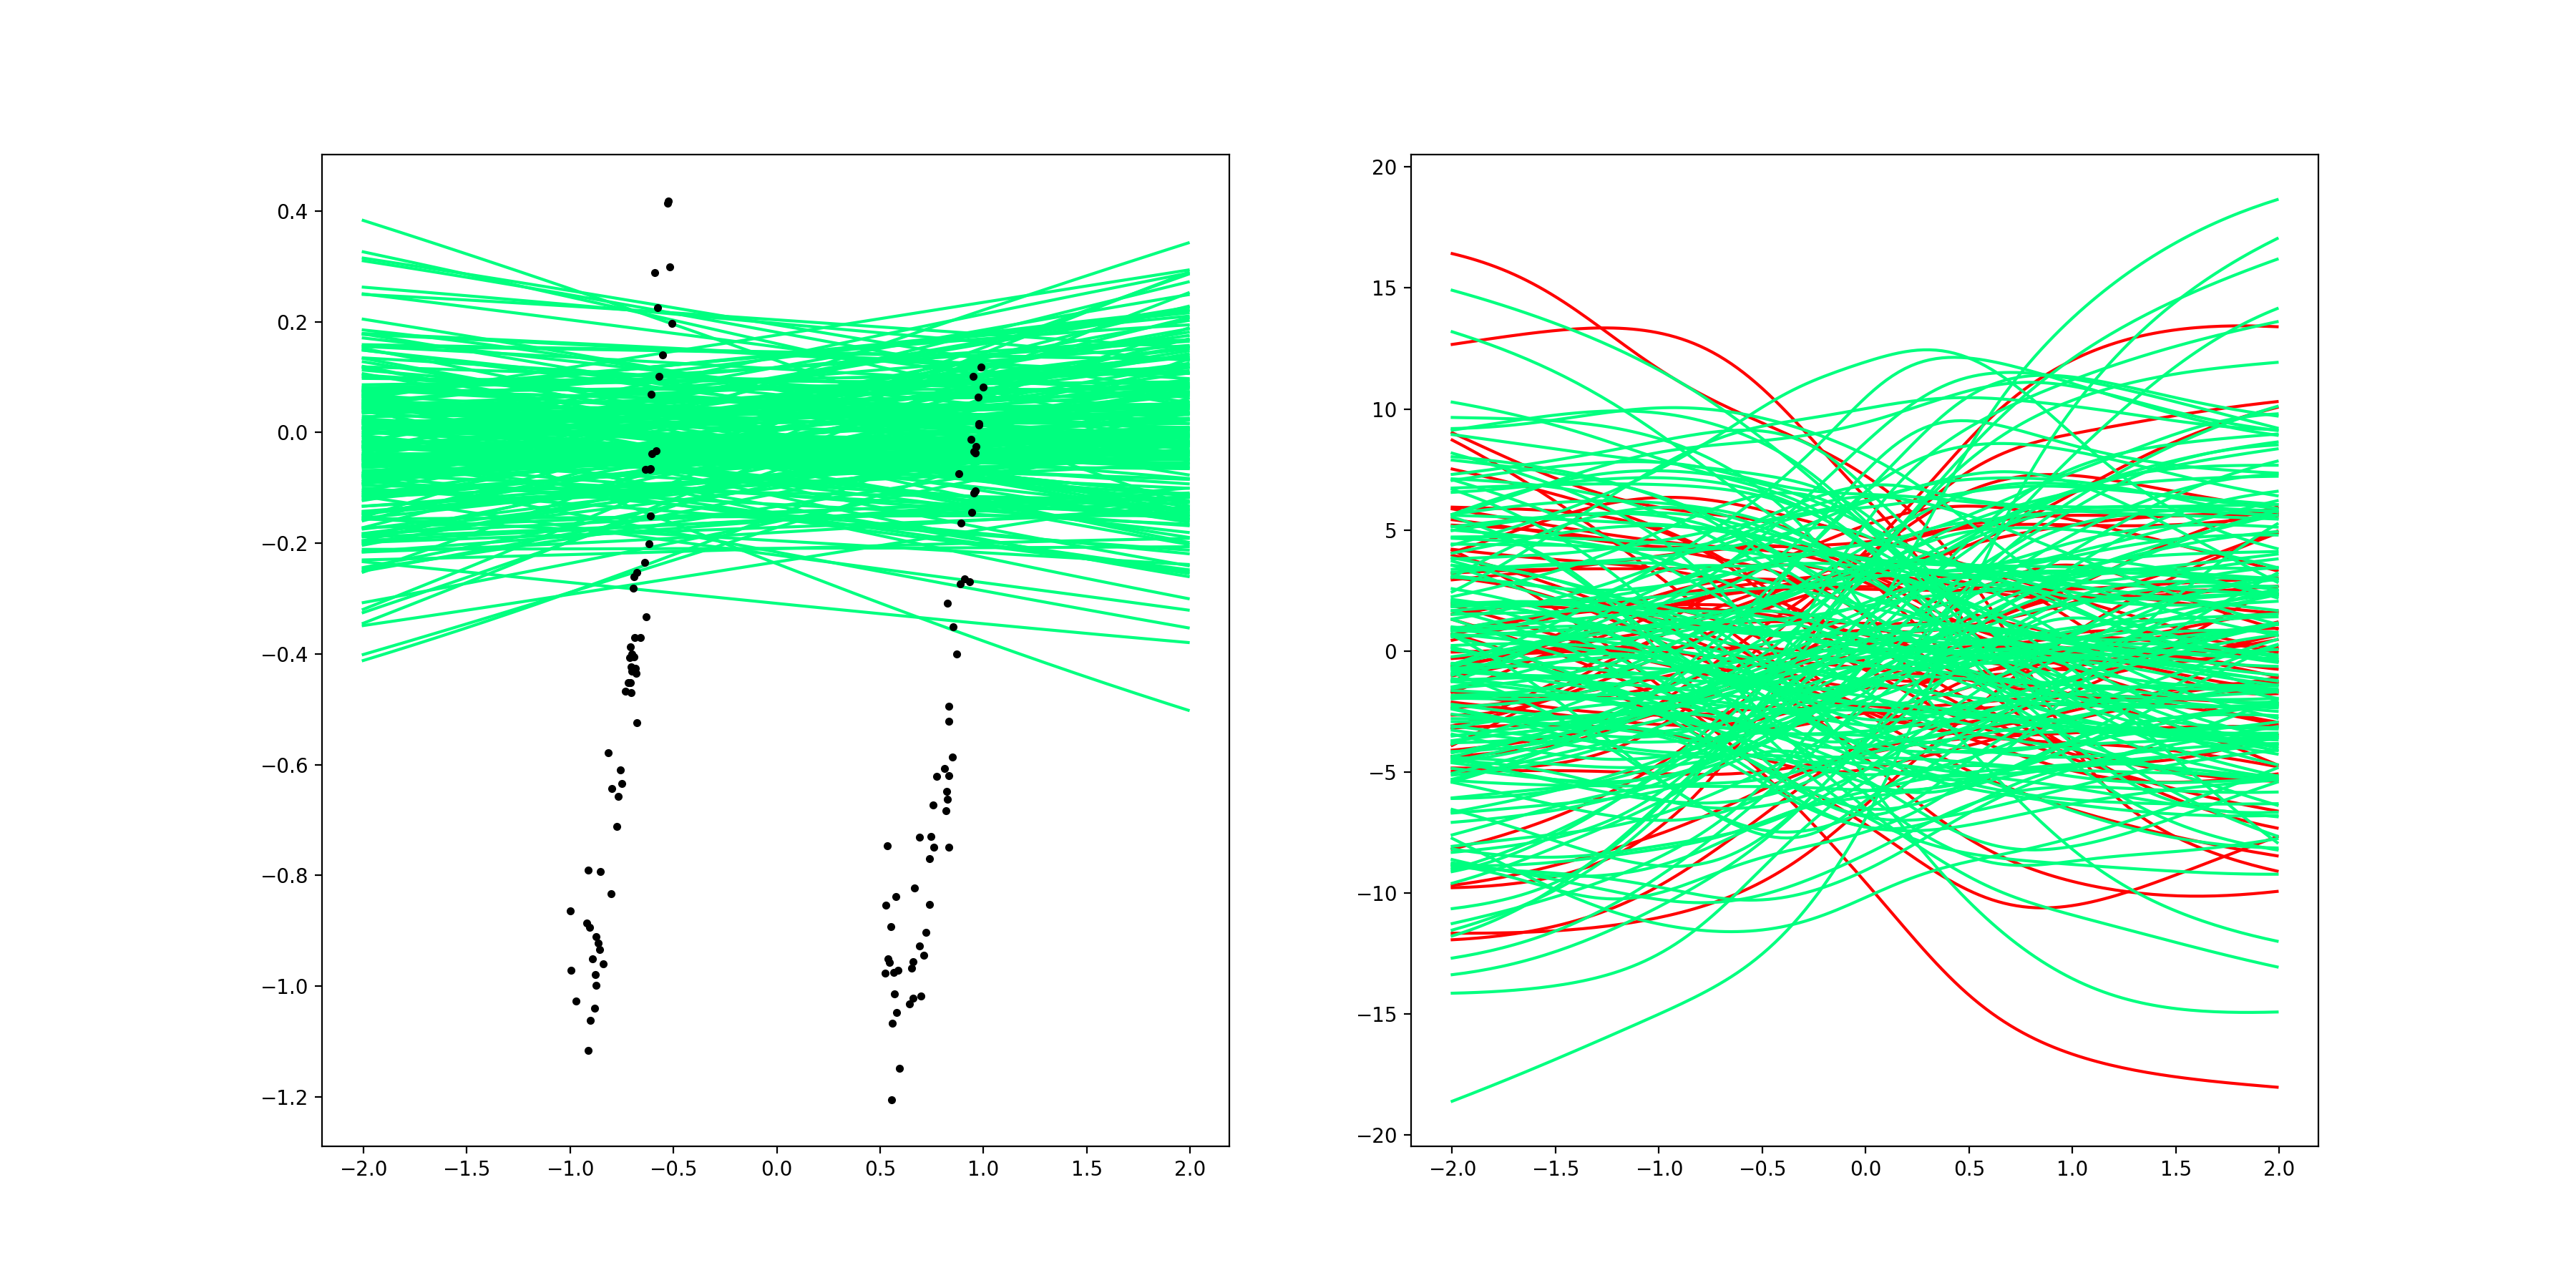

In [38]:
class LivePlotNotebook(object):
    """
    Live plot using %matplotlib notebook in jupyter notebook
    
    Usage:
    ```
    import time
    liveplot = LivePlotNotebook()
    x=np.random.random((10,))
    for i in range(10):
        time.sleep(1)
        liveplot.update(
            x=x+np.random.random(x.shape)/10,
            actions=np.random.randint(0, 3, size=(10,))
        )
    ```
    
    url:
    """

    def __init__(self, G,D, n=200):
        %matplotlib notebook
        fig,(ax0,ax1) = plt.subplots(1,2, figsize=(18,9))
        fig.tight_layout
        self.n=n
        x_lin=torch.arange(-2.,2.,0.03).to(device)
        self.x_lin=x_lin
        
        
        z = Tensor(np.random.normal(0, 1, (n, lat_dim)))
        self.z=z
        
        prior=Tensor(np.random.normal(0, 1, (n, param_count)))
        self.prior=prior
        
        ax0.scatter(X_train.cpu(), y_train.cpu(), marker='.',color='black',zorder=4)
        
        theta_fake=G(z)
        for i in range(n):
            y_pred_fake = prediction(x_lin, theta_fake[i,:].unsqueeze(0))
            ax0.plot(x_lin.detach().cpu().numpy(), y_pred_fake.squeeze(0).detach().cpu().numpy(), color='springgreen')
            
            y_pred = prediction(x_lin, prior[i,:].unsqueeze(0))
            d=discriminator(prior[i,:]).detach().squeeze().cpu()
            if d>0.:
                ax1.plot(x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), color='springgreen', zorder=1)
            if d<0.:
                ax1.plot(x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), color='red', zorder=0)

        
        self.ax0 = ax0
        self.ax1 = ax1
        self.fig = fig

    def update(self, G,D):             
        # update price
        self.ax0.clear()
        self.ax1.clear()
        theta_fake=G(self.z)
        self.ax0.scatter(X_train.cpu(), y_train.cpu(), marker='.',color='black',zorder=4)
        
        for i in range(self.n):
            y_pred_fake = prediction(self.x_lin, theta_fake[i,:].unsqueeze(0))
            self.ax0.plot(self.x_lin.detach().cpu().numpy(), y_pred_fake.squeeze(0).detach().cpu().numpy(), color='springgreen')
            
            y_pred = prediction(self.x_lin, self.prior[i,:].unsqueeze(0))
            d=discriminator(self.prior[i,:]).detach().squeeze().cpu()
            if d>0.:
                self.ax1.plot(self.x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), color='springgreen', zorder=1)
            if d<0.:
                self.ax1.plot(self.x_lin.detach().cpu().numpy(), y_pred.squeeze(0).detach().cpu().numpy(), color='red', zorder=0)

        self.fig.canvas.draw()
        
liveplot = LivePlotNotebook(generator,discriminator,n=200)  

In [43]:
b1=0.5 #0.5
b2=0.9999
lr_g=0.0002#0.004
lr_d=0.0002 #0.002 #0.001
# Optimizers
#logEvidence=torch.tensor(0., device=device).requires_grad_(True)


#optimizer_E = torch.optim.Adam([logEvidence], lr=lr_g, betas=(.9, b2))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(b1, b2))





<IPython.core.display.Javascript object>


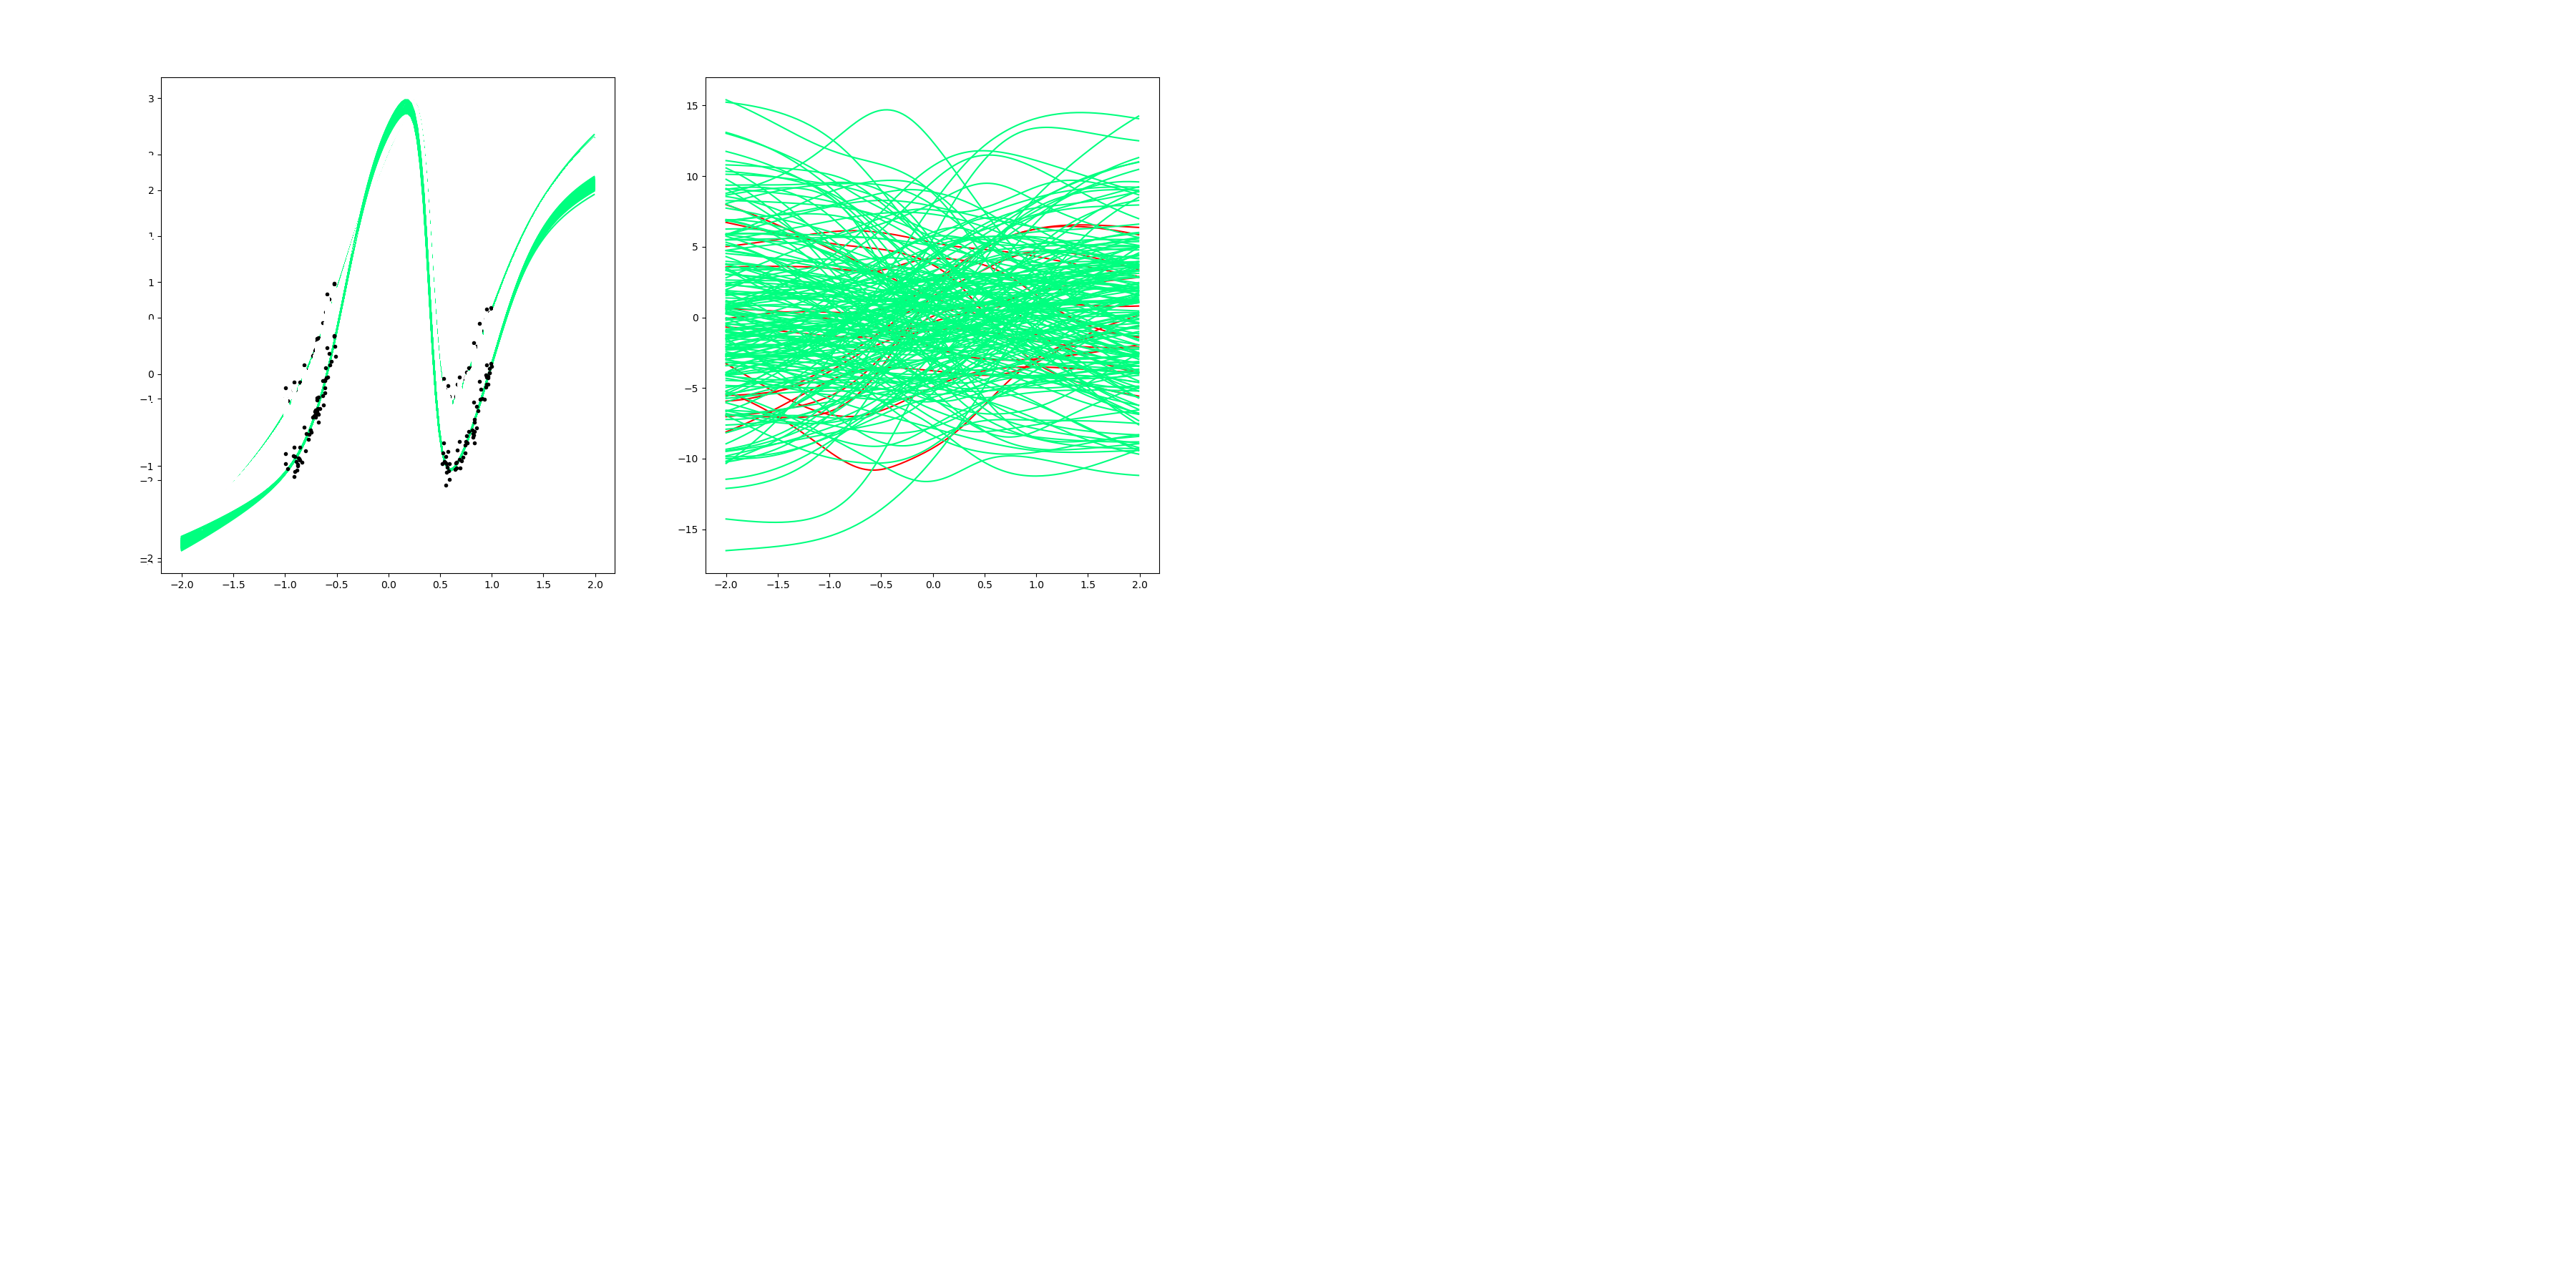

 33%|███▎      | 33071/100000 [12:59<18:45, 59.48it/s, D=0.0831, G=-103]    

In [ ]:
# ----------
#  Training
# ----------

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation



n_epochs=100000

n_fake_samples=500

n_critic=5

lambda_NP=.1

liveplot = LivePlotNotebook(generator,discriminator,n=200)    


with trange(n_epochs) as tr:
    for epoch in tr:

        # Configure input
        real_X, real_y =X_train, y_train

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        optimizer_E.zero_grad()
        
        # Sample noise as generator input
        z = Tensor(np.random.normal(0, 1, (n_fake_samples, lat_dim)))
        # Generate a batch of fake paramters
        fake_params = generator(z)
        prior_params=Tensor(np.random.normal(0, 1, (n_fake_samples, param_count)))

        # Real images
        #real_validity = torch.mul(discriminator(prior_params),(loglikelihood(prior_params)-logEvidence).unsqueeze(-1).exp())
        real_validity = discriminator(prior_params)
        # Fake images
        fake_validity = discriminator(fake_params)
        # Gradient penalty
        norm_penalty  = compute_norm_penalty(discriminator, prior_params, fake_params)
        grad_penalty = compute_gradient_penalty(discriminator, prior_params, fake_params)
        # Adversarial loss
        d_loss = -torch.mean(real_validity)   + torch.mean(fake_validity)+lambda_NP*grad_penalty+ .1*norm_penalty 
        d_loss.backward()
        optimizer_D.step()
        
        optimizer_G.zero_grad()


        

        # Train the generator every n_critic steps
        if epoch % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Sample noise as generator input
            z = Tensor(np.random.normal(0, 1, (n_fake_samples, lat_dim)))
            # Generate a batch of fake paramters
            fake_params = generator(z)
            prior_params=Tensor(np.random.normal(0, 1, (n_fake_samples, param_count)))

            # Real images
            #real_validity = torch.mul(discriminator(prior_params),(loglikelihood(prior_params)-logEvidence).unsqueeze(-1).exp())
            real_validity = discriminator(prior_params)
            # Fake images
            fake_validity = discriminator(fake_params)
            # Adversarial loss
            W = torch.mean(real_validity) - torch.mean(fake_validity)
            g_loss = W - loglikelihood(fake_params).mean()
            g_loss.backward()
            optimizer_G.step()

        tr.set_postfix(D=d_loss.item(), G=g_loss.item(), W=W.item())
        
        if epoch % 100 == 0:
            liveplot.update(generator,discriminator)
            #z = Tensor(np.random.normal(0, 1, (200, lat_dim)))
            #theta=generator(z)

            #fig=setup.makePlot(theta,device)
            #plt.pause(1.)
            #plt.close()
            #showd(discriminator,200)
        

plt.show()

    